In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from typing import Optional, Tuple, Union
from ot import emd2_1d
from dem.models.components.optimal_transport import wasserstein
from dem.utils.data_utils import remove_mean
from dem.utils.logging_utils import fig_to_image

In [2]:
import sys
sys.path.append('..')


In [3]:
from dem.energies.multi_double_well_energy import MultiDoubleWellEnergy
from dem.energies.lennardjones_energy import LennardJonesPotential, LennardJonesEnergy

In [4]:
energy= LennardJonesEnergy(
            dimensionality= 165,
            n_particles= 55,
            data_path= "../data/test_split_LJ55-1000-part1.npy",
            data_path_train= "../data/train_split_LJ55-1000-part1.npy",
            data_path_val= "../data/val_split_LJ55-1000-part1.npy",
            device='cpu',
            data_normalization_factor= 1.0,
            is_molecule= True)

In [5]:
def _calc_dist_total_var(
    gt_samples: torch.Tensor,
    latest_samples: torch.Tensor,
    system_shape: Union[torch.Size, Tuple[int]],
    energy_function    ) -> torch.Tensor:
    x = gt_samples.view(*system_shape)
    y = latest_samples.view(*system_shape) if latest_samples.device == "cpu" else latest_samples.detach().cpu().view(*system_shape)
    
    if x.size(-1) == 3:
        generated_samples_dists = (
            energy_function.interatomic_dist(x).cpu().numpy().reshape(-1),
        )
        data_set_dists = energy_function.interatomic_dist(y).cpu().numpy().reshape(-1)

        H_data_set, x_data_set = torch.histogram(data_set_dists, bins=200)
        H_generated_samples, _ = torch.histogram(generated_samples_dists, bins=(x_data_set))
        total_var = (
            0.5
            * torch.abs(
                H_data_set / H_data_set.sum() - H_generated_samples / H_generated_samples.sum()
            ).sum()
        )
    else:
        H_data_set_x, x_data_set = torch.histogram(x[:, 0], bins=200)
        H_data_set_y, _ = torch.histogram(x[:, 1], bins=(x_data_set))
        H_generated_samples_x, _ = torch.histogram(y[:, 0], bins=(x_data_set))
        H_generated_samples_y, _ = torch.histogram(y[:, 1], bins=(x_data_set))
        total_var = (
            0.5
            * (
                torch.abs(
                    H_data_set_x / H_data_set_x.sum() - H_generated_samples_x / H_generated_samples_x.sum()
                ) +
                torch.abs(
                    H_data_set_y / H_data_set_y.sum() - H_generated_samples_y / H_generated_samples_y.sum()
                )
            ).sum()
        )
    return total_var

def get_hist_metrics(samples,test,prefix="",range=(0,7)):
    metrics={}
    samples_hist,_=np.histogram(samples.view(-1),bins=100,density=True,range=range)
    test_hist,_=np.histogram(test.view(-1),bins=100,density=True,range=range)
    #w2 distance
    w2=emd2_1d(samples.view(-1),test.view(-1),metric="euclidean")
    #l2 distance
    l2_distance = np.linalg.norm(samples_hist - test_hist)
    metrics[prefix+"L2 Distance"]=l2_distance
    metrics[prefix+"W2 Distance"]=w2
    return metrics

def compute_metrics(energy,initial_samples,test_set,plot_figs=True):
    log_metrics={}
    current_samples_idx=torch.multinomial(torch.ones(initial_samples.size()[0]),test_set.size()[0], replacement=False)
    current_samples=initial_samples[current_samples_idx]
    if energy.is_molecule:
        current_samples=remove_mean(current_samples,energy.n_particles,energy.n_spatial_dim)
        test_set=remove_mean(test_set,energy.n_particles,energy.n_spatial_dim)
        dist_samples = energy.interatomic_dist(current_samples).detach().cpu()
        dist_test = energy.interatomic_dist(test_set).detach().cpu()
        
        dist_metrics=get_hist_metrics(dist_samples,dist_test,prefix="Interatomic Distance ",range=(0,7))
        if energy.n_particles == 13:
            min_energy = -60
            max_energy = 0
        elif energy.n_particles == 55:
            min_energy = -380
            max_energy = -180
        else:
            min_energy = -26
            max_energy = 0
        energy_samples = -energy(current_samples).detach().cpu()
        energy_test = -energy(test_set).detach().cpu()
        energy_metrics=get_hist_metrics(energy_samples,energy_test,prefix="Energy ",range=(min_energy,max_energy))
        log_metrics.update(dist_metrics)
        log_metrics.update(energy_metrics)
    current_samples=current_samples.cpu()
    test_set=test_set.cpu()
    w2=wasserstein(test_set,current_samples,power=2)
    tv=_calc_dist_total_var(test_set,current_samples,current_samples.shape,energy)
    log_metrics["W2"]=w2
    log_metrics["Total Variation"]=tv
    return log_metrics
    


In [6]:
dataset=np.load("../lj55_long_3.npy")
print(dataset.shape)
np.random.seed(0)
dataset=np.random.permutation(dataset)
test_set=dataset[:1000]
dataset=dataset[1000:]
print(test_set.shape)
np.save("../test_lj55_long-1000.npy",test_set)

(12800, 165)
(1000, 165)


In [7]:
torch_dataset=torch.tensor(dataset)
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]

for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch_test_set)
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:29<00:00,  3.59s/it]


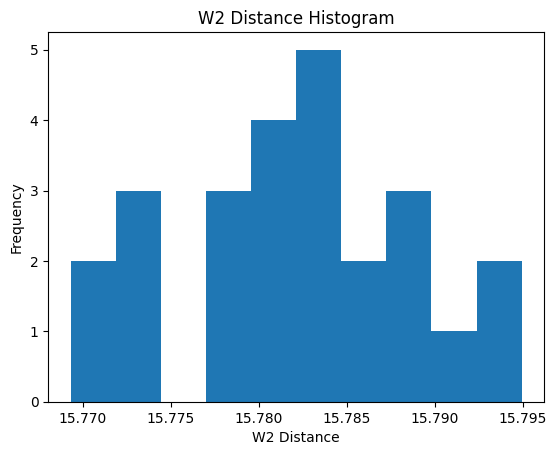

W2 Distance Mean:  15.78182085712333
W2 Distance Std:  0.006987254710337944


In [ ]:
plt.figure()
plt.hist(w2s,bins=10)
plt.xlabel("W2 Distance")
plt.ylabel("Frequency")
plt.title("W2 Distance Histogram")
plt.show()

print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))

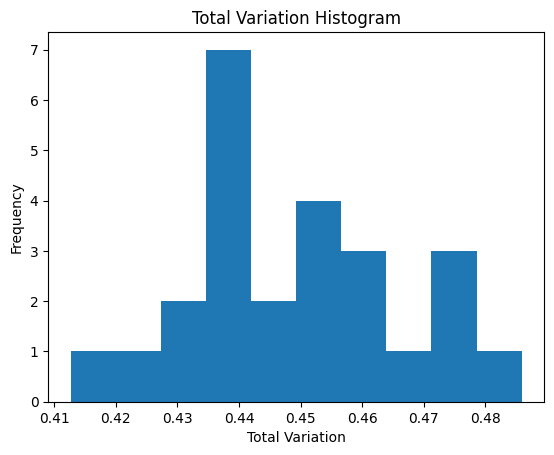

Total Variation Mean:  0.449228
Total Variation Std:  0.017374659


In [ ]:
plt.figure()
plt.hist(tvs,bins=10)
plt.xlabel("Total Variation")
plt.ylabel("Frequency")
plt.title("Total Variation Histogram")
plt.show()

print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))

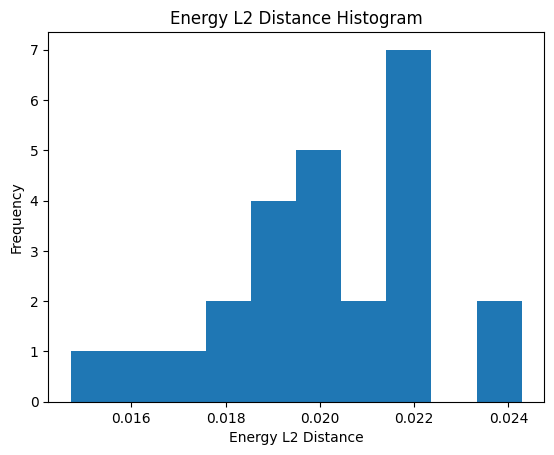

Energy L2 Distance Mean:  0.020132999289410317
Energy L2 Distance Std:  0.002195982607536729


In [ ]:
plt.figure()
plt.hist(energy_l2s,bins=10)
plt.xlabel("Energy L2 Distance")
plt.ylabel("Frequency")
plt.title("Energy L2 Distance Histogram")
plt.show()

print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))

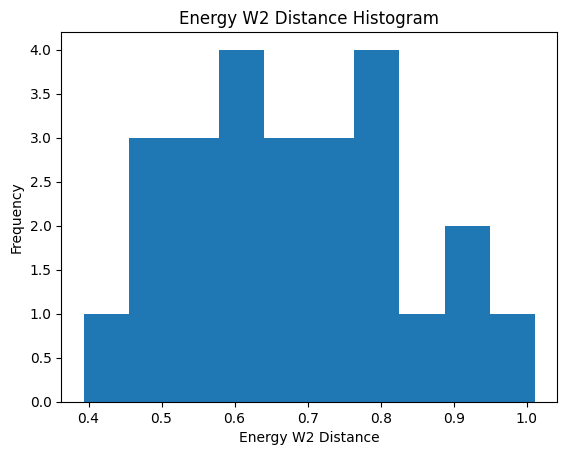

Energy W2 Distance Mean:  0.6818104
Energy W2 Distance Std:  0.15451269


In [ ]:
plt.figure()
plt.hist(energy_w2s,bins=10)
plt.xlabel("Energy W2 Distance")
plt.ylabel("Frequency")
plt.title("Energy W2 Distance Histogram")
plt.show()

print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))

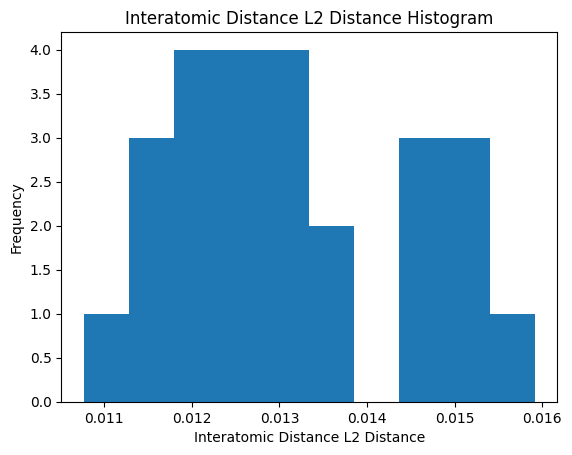

Interatomic Distance L2 Distance Mean:  0.013182222142166987
Interatomic Distance L2 Distance Std:  0.0013655342216706914


In [ ]:
plt.figure()
plt.hist(interatomic_l2s,bins=10)
plt.xlabel("Interatomic Distance L2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance L2 Distance Histogram")
plt.show()

print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))

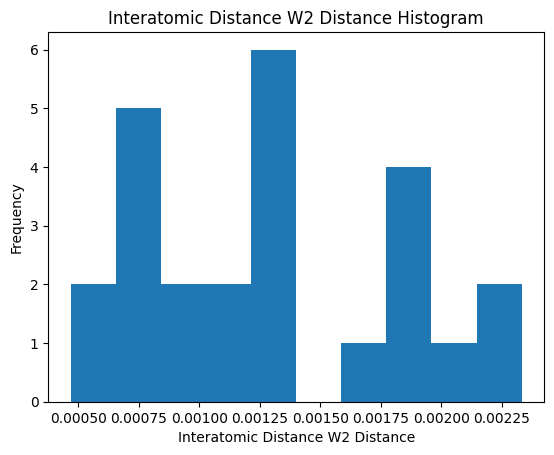

Interatomic Distance W2 Distance Mean:  0.0012928358
Interatomic Distance W2 Distance Std:  0.00054286176


In [13]:
plt.figure()
plt.hist(interatomic_w2s,bins=10)
plt.xlabel("Interatomic Distance W2 Distance")
plt.ylabel("Frequency")
plt.title("Interatomic Distance W2 Distance Histogram")
plt.show()

print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

long simulation endpoint vs current reference

In [14]:
simulation_dataset=np.load("../lj55_long.npy")
torch_simulation_dataset=torch.tensor(simulation_dataset)
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in tqdm.tqdm(range(25)):
    current_samples_idx=torch.multinomial(torch.ones(torch_simulation_dataset.shape[0]),torch_test_set.shape[0], replacement=False)
    current_samples=torch_simulation_dataset[current_samples_idx]
    metrics=compute_metrics(energy,current_samples,torch.tensor(test_set))
    w2s.append(metrics["W2"])
    tvs.append(metrics["Total Variation"])
    energy_l2s.append(metrics["Energy L2 Distance"])
    energy_w2s.append(metrics["Energy W2 Distance"])
    interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
    interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:13<00:00,  2.93s/it]

W2 Distance Mean:  15.923833151305422
W2 Distance Std:  0.0094891283302109
Total Variation Mean:  0.46516564
Total Variation Std:  0.015262796
Energy L2 Distance Mean:  0.024680213992256714
Energy L2 Distance Std:  0.002804823933229307
Energy W2 Distance Mean:  0.9031842
Energy W2 Distance Std:  0.24580121
Interatomic Distance L2 Distance Mean:  0.018519951809309744
Interatomic Distance L2 Distance Std:  0.0015950109168042597
Interatomic Distance W2 Distance Mean:  0.0014579028
Interatomic Distance W2 Distance Std:  0.00055611687


short simulation endpoints vs current reference

In [15]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../lj55_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

W2 Distance Mean:  16.480383679421823
W2 Distance Std:  0.049855489348761675
Total Variation Mean:  0.7450204
Total Variation Std:  0.12522076
Energy L2 Distance Mean:  0.023523996717886752
Energy L2 Distance Std:  0.0024044913010558486
Energy W2 Distance Mean:  0.96048146
Energy W2 Distance Std:  0.27949983
Interatomic Distance L2 Distance Mean:  0.01811257570962497
Interatomic Distance L2 Distance Std:  0.001894474585341488
Interatomic Distance W2 Distance Mean:  0.001807586
Interatomic Distance W2 Distance Std:  0.0006025359


short simulation endpoints vs new reference

In [16]:
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../lj55_endpoint{}.npy'.format(i)
    endpoint_samples=np.load(endpoint)
    torch_endpoint_samples=torch.tensor(endpoint_samples)
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

W2 Distance Mean:  16.423961528509786
W2 Distance Std:  0.024354723062705134
Total Variation Mean:  0.75072753
Total Variation Std:  0.13675092
Energy L2 Distance Mean:  0.019695019544613022
Energy L2 Distance Std:  0.002765177234339788
Energy W2 Distance Mean:  0.8608026
Energy W2 Distance Std:  0.38476896
Interatomic Distance L2 Distance Mean:  0.013429901727810296
Interatomic Distance L2 Distance Std:  0.0013021818827023076
Interatomic Distance W2 Distance Mean:  0.0018488452
Interatomic Distance W2 Distance Std:  0.00083152583


IDEM vs current reference

In [17]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IDEM_samples/LJ55_{}_samples_10000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2538985/104655804.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  7173045564.802001
W2 Distance Std:  24209181665.958157
Total Variation Mean:  0.46345696
Total Variation Std:  0.01264954
Energy L2 Distance Mean:  0.06808933043846638
Energy L2 Distance Std:  0.03947056281051972
Energy W2 Distance Mean:  3.1876858e+20
Energy W2 Distance Std:  inf
Interatomic Distance L2 Distance Mean:  0.37180995359241537
Interatomic Distance L2 Distance Std:  0.0830046339219982
Interatomic Distance W2 Distance Mean:  11735168.0
Interatomic Distance W2 Distance Std:  39605796.0


/net/galaxy/home/koes/rishal/.conda/envs/rebyob/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


IDEM vs new reference

In [18]:
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
w2s=[]
tvs=[]
energy_l2s=[]
energy_w2s=[]
interatomic_l2s=[]
interatomic_w2s=[]
for i in range(1,6):
    endpoint='../IDEM_samples/LJ55_{}_samples_10000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        metrics=compute_metrics(energy,current_samples,torch_test_set)
        w2s.append(metrics["W2"])
        tvs.append(metrics["Total Variation"])
        energy_l2s.append(metrics["Energy L2 Distance"])
        energy_w2s.append(metrics["Energy W2 Distance"])
        interatomic_l2s.append(metrics["Interatomic Distance L2 Distance"])
        interatomic_w2s.append(metrics["Interatomic Distance W2 Distance"])
print("W2 Distance Mean: ",np.mean(w2s))
print("W2 Distance Std: ",np.std(w2s))
print("Total Variation Mean: ",np.mean(tvs))
print("Total Variation Std: ",np.std(tvs))
print("Energy L2 Distance Mean: ",np.mean(energy_l2s))
print("Energy L2 Distance Std: ",np.std(energy_l2s))
print("Energy W2 Distance Mean: ",np.mean(energy_w2s))
print("Energy W2 Distance Std: ",np.std(energy_w2s))
print("Interatomic Distance L2 Distance Mean: ",np.mean(interatomic_l2s))
print("Interatomic Distance L2 Distance Std: ",np.std(interatomic_l2s))
print("Interatomic Distance W2 Distance Mean: ",np.mean(interatomic_w2s))
print("Interatomic Distance W2 Distance Std: ",np.std(interatomic_w2s))

/tmp/ipykernel_2538985/594752315.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


W2 Distance Mean:  3656819604.627873
W2 Distance Std:  17476689882.688778
Total Variation Mean:  0.45629594
Total Variation Std:  0.018275587
Energy L2 Distance Mean:  0.0680079715620666
Energy L2 Distance Std:  0.04143185853494593
Energy W2 Distance Mean:  1.5940355e+20
Energy W2 Distance Std:  inf
Interatomic Distance L2 Distance Mean:  0.3680627383570596
Interatomic Distance L2 Distance Std:  0.08053484216586425
Interatomic Distance W2 Distance Mean:  5947931.5
Interatomic Distance W2 Distance Std:  28424450.0


Interatomic distance distribution

In [19]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_current_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
dist_new_reference = energy.interatomic_dist(torch_test_set).detach().cpu()
endpoint='../lj55_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_mcmc_reference = energy.interatomic_dist(current_samples).detach().cpu()
endpoint='../IDEM_samples/LJ55_1_samples_10000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
dist_idem_reference = energy.interatomic_dist(current_samples).detach().cpu()

/tmp/ipykernel_2538985/2841505720.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


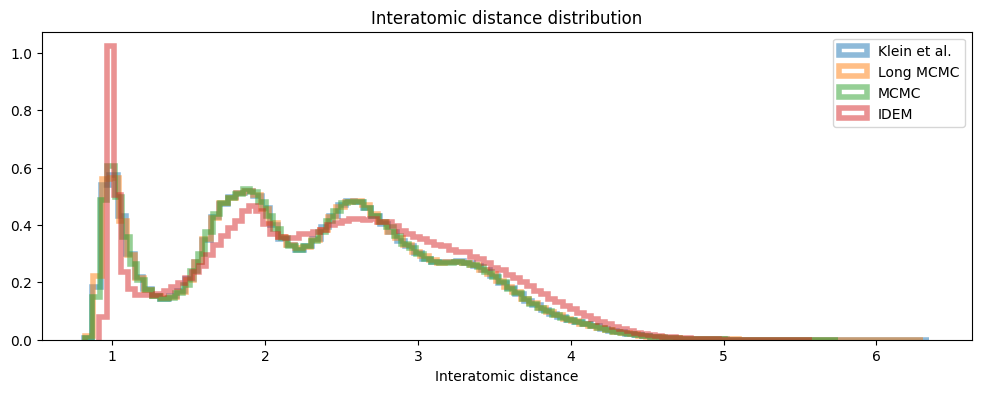

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(
        dist_current_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_new_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_mcmc_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.hist(
        dist_idem_reference.view(-1),
        bins=100,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        )
ax.set_xlabel("Interatomic distance")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM"])
ax.set_title("Interatomic distance distribution")
figure=fig_to_image(fig)
figure.save("lj55_interatomic_distance_distribution.png")

Energy distribution

In [21]:
test_set=np.load("../data/test_split_LJ55-1000-part1.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_current_reference = -energy(torch_test_set).detach().cpu()
test_set=np.load("../test_lj55_long-1000.npy")[-1000:]
torch_test_set=torch.tensor(test_set)
energy_new_reference = -energy(torch_test_set).detach().cpu()
endpoint='../lj55_endpoint1.npy'
endpoint_samples=np.load(endpoint)
torch_endpoint_samples=torch.tensor(endpoint_samples)
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_mcmc_reference = -energy(current_samples).detach().cpu()
endpoint='../IDEM_samples/LJ55_1_samples_10000.pt'
torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),torch_test_set.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
energy_idem_reference = -energy(current_samples).detach().cpu()

/tmp/ipykernel_2538985/3334898310.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint,map_location=torch.device('cpu'))


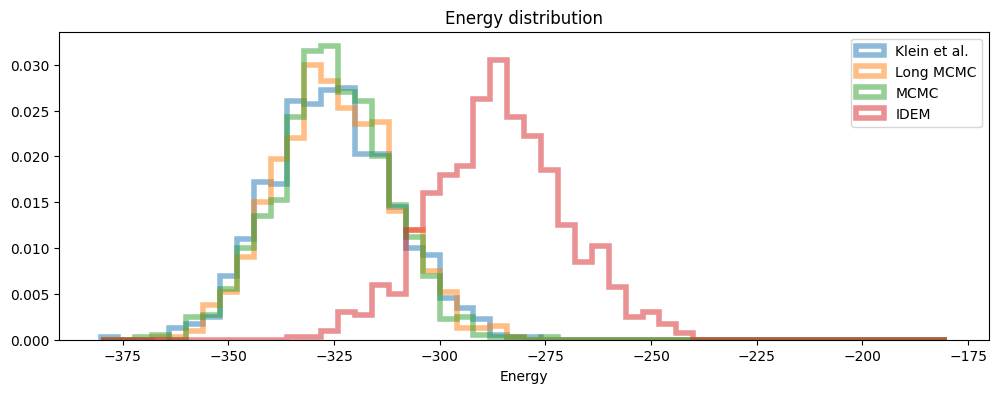

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
min_energy = -380
max_energy = -180
ax.hist(
        energy_current_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_new_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_mcmc_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.hist(
        energy_idem_reference.view(-1),
        bins=50,
        alpha=0.5,
        density=True,
        histtype="step",
        linewidth=4,
        range=(min_energy,max_energy)
        )
ax.set_xlabel("Energy")
ax.legend(["Klein et al.", "Long MCMC", "MCMC", "IDEM"])
ax.set_title("Energy distribution")
figure=fig_to_image(fig)
figure.save("lj55_energy_distribution.png")